In [1]:
using RCall, DataFrames, LogTopReg, Distributions
import Lazy.@>, Lazy.@>>


Attaching package: ‘dplyr’

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

data.table 1.10.0
  The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way
  Documentation: ?data.table, example(data.table) and browseVignettes("data.table")
  Release notes, videos and slides: http://r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [2]:
using LogTopReg
include("../juliafromR.jl");
Y,X,pss0 = getfocaldata();
Z = rcopy("Z");

  Bumped column 5 to type character on data row 6913, field contains '208B0'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.
Warning in fread(files[i]) :
  Bumped column 15 to type character on data row 57995, field contains 'sister'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0',

In [4]:
R"library(rstan)"
R"topetho <- stan_model('~/code/topetho/categorical_topetho.stan')";
R"dat <- list(n=nrow(Y),K=3,B=ncol(Y)-3,Bs=sapply(Y[,-c(1:3),with=F],max),Y=as.matrix(Y[,-c(1:3),with=F]),alpha=1)";

rstan (Version 2.12.1, packaged: 2016-09-11 13:07:50 UTC, GitRev: 85f7a56811da)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


make: *** [file16cd44cd4acf.o] Interrupt

ERROR(s) during compilation: source code errors or compiler configuration errors!

Program source:
  1: 
  2: // includes from the plugin
  3: 
  4: 
  5: // user includes
  6: #define STAN__SERVICES__COMMAND_HPP// Code generated by Stan version 2.12
  7: 
  8: #include <stan/model/model_header.hpp>
  9: 
 10: namespace model16cd6cc8981d_categorical_topetho_namespace {
 11: 
 12: using std::istream;
 13: using std::string;
 14: using std::stringstream;
 15: using std::vector;
 16: using stan::io::dump;
 17: using stan::math::lgamma;
 18: using stan::model::prob_grad;
 19: using namespace stan::math;
 20: 
 21: typedef Eigen::Matrix<double,Eigen::Dynamic,1> vector_d;
 22: typedef Eigen::Matrix<double,1,Eigen::Dynamic> row_vector_d;
 23: typedef Eigen::Matrix<double,Eigen::Dynamic,Eigen::Dynamic> matrix_d;
 24: 
 25: static int current_statement_begin__;
 26: 
 27: class model16cd6cc8981d_categorical_topetho : public prob_grad {
 28: private:
 29

LoadError: LoadError: RCall.jl: Warning: running command '/usr/lib/R/bin/R CMD SHLIB file16cd44cd4acf.cpp 2> file16cd44cd4acf.cpp.err.txt' had status 1
Error in compileCode(f, code, language = language, verbose = verbose) : 
  Compilation ERROR, function(s)/method(s) not created! make: *** [file16cd44cd4acf.o] Interrupt

while loading In[4], in expression starting on line 79

In [5]:
runs = 10;
ll = Vector{Float64}(runs);
r = Vector{Array{Float64,2}}(runs);
for i in 1:runs
    R"optout <- optimizing(topetho,dat,verbose=F)";
    ll[i] = rcopy(R"optout$value");
    r[i] = rcopy(R"optout$par[str_detect(names(optout$par),'^r\\[')] %>% matrix(nrow=dat$K,ncol=dat$n,byrow = T)")
end

LoadError: RCall.jl: Error: could not find function "optimizing"


In [3]:
r = readcsv("/home/seth/analysis/logtopreg/optimout_FKKR_forpaper_rep.csv");

In [35]:
zflat = mapslices(x -> rand(Categorical(x)),r,2);
z = Vector{Vector{Int64}}(length(Y));
nd = map(x -> size(x)[2],Y);
guh = 1;
for i in 1:length(Y)
    z[i] = zflat[guh:(guh+nd[i]-1)];
    guh += nd[i];
end

In [36]:
K = 10;
niter = 50000;
thin = 50;
ns = div(niter,thin);
hyper = hyperparameter(τ0_u = 0.01,ν0_u=0.33,ν0_σ2η=0.01,σ0_σ2η = 0.01,τ0_τ = 0.01,ν0_τ = 0.01,τ_β = 1.0);

In [37]:
@time fit7 = topiclmm(Y,X,Z,pss0,zinit=z,K,hyper,iter=niter,thin=thin);

26304.235668 seconds (303.59 G allocations: 11.403 TB, 7.00% gc time)


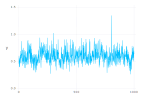

In [216]:
i = 7;
plot(y=sqrt(fit7[:σ2][i,:]),Geom.line)

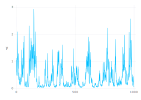

In [218]:
plot(y=sqrt(fit7[:τ_u][i,:]),Geom.line)

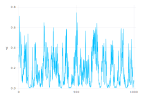

In [48]:
bl = 2;
i = 10;
f = fit7;
σ2i = f[:σ2][i,:] + f[:σ2][bl,:];
σ2Ai = f[:τ_u][i,:].*f[:σ2][i,:] + f[:τ_u][bl,:].*f[:σ2][bl,:];
h2 = σ2Ai./(σ2i.+σ2Ai)
plot(y=h2,Geom.line)

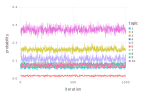

In [39]:
using Gadfly
mudat = DataFrame(probability = mapslices(softmax,fit7[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

In [38]:
writefit(fit7,"/home/seth/analysis/logtopreg/fitFKKR_A_fixed_2/")